In [1]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import librosa
import librosa.display
from swipe import *
import math

plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.constant_pitch(with_n = False)
    #self.tonic = self.find_tonic()
    #self.constant_pitch(with_n = True)

  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    #self.pitch = self.pitch.round(decimals = 2)

  def constant_pitch(self,with_n ):
    
    time_axis_80 = []
    pitch_80 = []
    k=[]
    
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    if(with_n):

      self.normalised_pitch=[]
      
      for i in self.pitch:
        self.normalised_pitch.append((12*np.log2(i/self.tonic)))
      
      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.normalised_pitch[i])
        time_axis_80.append(self.time_axis[i])
      # calculating the 1st order difference
      delta = 0.3

    else:

      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.pitch[i])
        time_axis_80.append(self.time_axis[i])
      delta = 8
      
    self.diff_n = np.diff(pitch_80)

    for i in range(len(self.diff_n)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(self.diff_n[i]<delta/2 and self.diff_n[i]>-delta/2):
        k.append((pitch_80[i],time_axis_80[i]))
    k = np.array(k)
    self.cpn,self.constant_pitch_time = k.T
    #self.constant_pitch_notes = [(i,j) for i,j in all_normalized_notes.items() if j in self.cpn]
  def find_tonic(self):
    def most_frequent(List): 
      counter = 0
      num = List[0] 
        
      for i in List: 
          curr_frequency = List.count(i) 
          if(curr_frequency> counter): 
              counter = curr_frequency 
              num = i 
    
      return num

    store_tonic_pa=list()
    store_tonic_ri2=list()
    store_tonic_ma1=list()
    store_tonic_ga3=list()
    store_tonic_ni3=list()
    floored=[]
    toniclist=[]
    """
    uniquepitch=set(self.cpn)
    uniquepitchfloor=[]
    for i in uniquepitch:
      i=math.floor(i)
      uniquepitchfloor.append(i)
    """
    uniquepitchfloor = list(self.cpn.round())
    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.49) and ((i/j) <1.51)):
              store_tonic_pa.append(j)
            if(((i/j)>1.1) and ((i/j) <1.14) ):
              store_tonic_ri2.append(j)
    if(store_tonic_pa):
      pa_to_sa=most_frequent(store_tonic_pa)
      toniclist.append(pa_to_sa)
    if(store_tonic_ri2):
      ri2_to_sa=most_frequent(store_tonic_ri2)
      toniclist.append(ri2_to_sa)

    if(abs(toniclist[1]-toniclist[0])< 5):
      # print(toniclist[0])
      return toniclist[0]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.29) and ((i/j) <1.35) ):
            
              store_tonic_ma1.append(j)
    if(store_tonic_ma1):
      ma1_to_sa=most_frequent(store_tonic_ma1)
      toniclist.append(ma1_to_sa)
    
    if((abs(toniclist[2]-toniclist[0])< 5) or (abs(toniclist[2]-toniclist[1])< 5)):
      # print(toniclist[2])
      return toniclist[2]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.2) and ((i/j) <1.27)):
              store_tonic_ga3.append(j)
    if(store_tonic_ga3):
      ga3_to_sa=most_frequent(store_tonic_ga3)
      toniclist.append(ga3_to_sa)

    if((abs(toniclist[3]-toniclist[0])< 5) or (abs(toniclist[3]-toniclist[1])< 5) or (abs(toniclist[3]-toniclist[2])< 5)):
      # print(toniclist[3])
      return toniclist[3]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.85) and ((i/j) <1.9) ):
              
              store_tonic_ni3.append(j)
    if(store_tonic_ni3):
      ni3_to_sa=most_frequent(store_tonic_ni3)
      toniclist.append(ni3_to_sa)
    
    if((abs(toniclist[4]-toniclist[0])< 5) or (abs(toniclist[4]-toniclist[1])< 5) or (abs(toniclist[4]-toniclist[2])< 5) or (abs(toniclist[4]-toniclist[3])< 5)):
      print(toniclist[4])
      return toniclist[4]
    # print("tonic not found sigh")
    # print(toniclist[0])
    return toniclist[0] #lets just assume Pa was there


In [0]:
#from Audio import *
ratios = {'Sa':1,'Ri1':16/15,'Ri2/Ga1':9/8,'Ga2/Ri3':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa':3/2,'Da1':8/5,
          'Da2/Ni1':5/3,'Ni2/Da3':9/5,'Ni3':15/8,'Sa2':2}

all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)

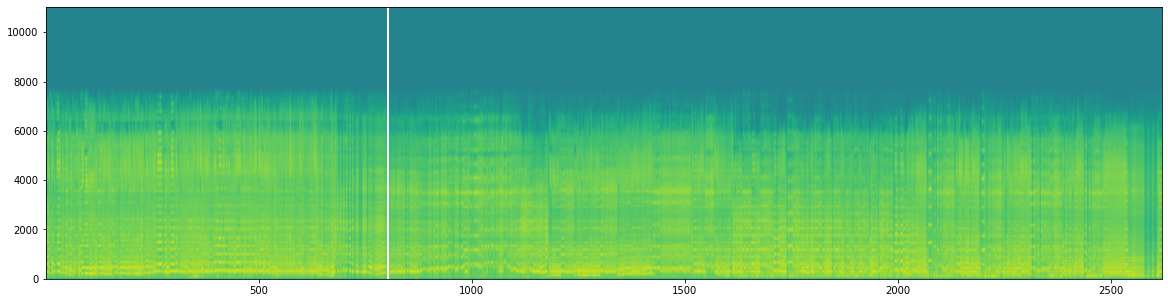

In [39]:
test = Audio('/content/drive/My Drive/Projects/AA/Music dataset/08-rAgam_tAnam_pallavi-bhairavi.mp3')

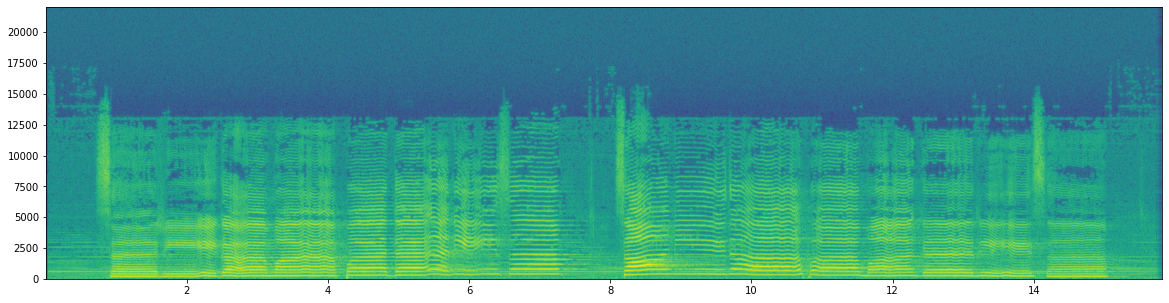

In [40]:
shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')

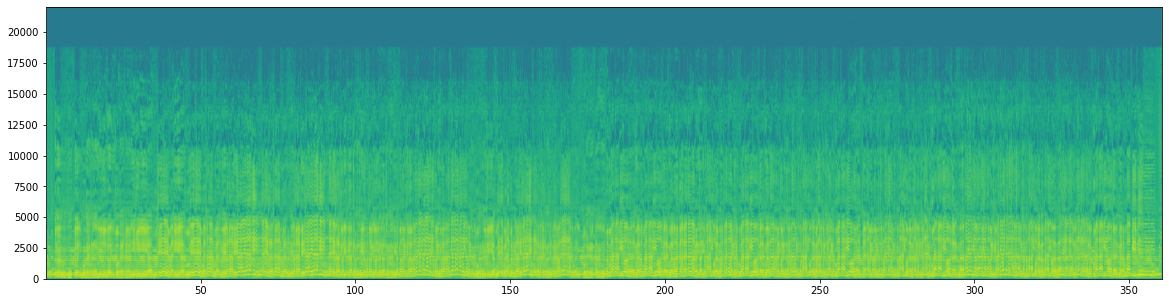

In [41]:
rkm = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')

In [0]:
#list(zip(shankarabarana.cpn[1:],shankarabarana.constant_pitch_time[1:],np.diff(shankarabarana.constant_pitch_time)))
#list(zip(shankarabarana.pitch[1:],np.diff(shankarabarana.pitch)))
index = []
diff_p = np.diff(shankarabarana.pitch)
for i in range(0,len(diff_p)):
  if abs(diff_p[i]>4) and shankarabarana.pitch[i] not in shankarabarana.cpn:
    index.append([shankarabarana.time_axis[i],shankarabarana.pitch[i]]) 

In [0]:
index = np.array(index)
gg,hh = index.T


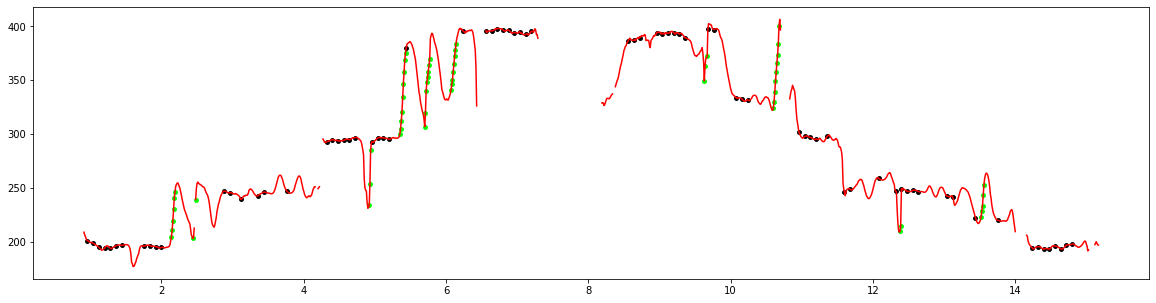

In [126]:
plt.scatter(shankarabarana.constant_pitch_time,shankarabarana.cpn,s =15,c='0')
plt.scatter(gg,hh,s=15,c='#00FF00')
plt.plot(shankarabarana.time_axis,shankarabarana.pitch,c= '#FF0000')

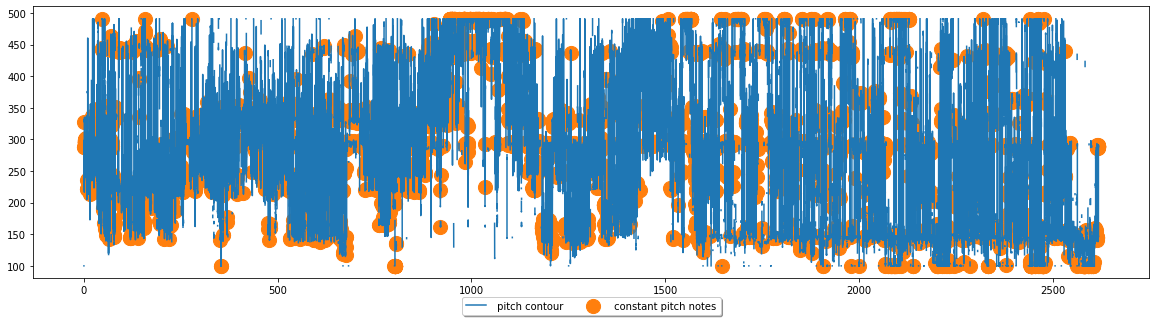

In [128]:
fig, ax = plt.subplots()
ax.plot(test.time_axis,test.pitch,label = ' pitch contour')
ax.scatter(test.constant_pitch_time,test.cpn,s=200,c = '#ff7f0e',label = ' constant pitch notes')
#ax.hlines(shankarabarana.constant_pitch_notes,[0],[shankarabarana.time_axis[-1]])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()